<Axes: >

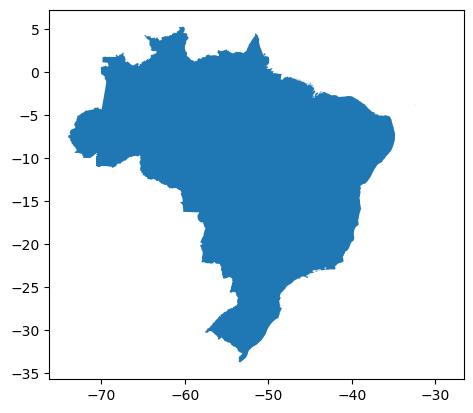

In [1]:
import pandas as pd
import geopandas as gpd

boundaries = gpd.read_file("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/misc/gadm_410-BRA.geojson", engine="pyogrio")
boundaries.plot()

In [1]:
import cdsapi

c = cdsapi.Client()

c.retrieve(
    'satellite-cloud-properties',
    {
        'format': 'zip',
        'product_family': 'clara_a3',
        'origin': 'eumetsat',
        'variable': 'cloud_fraction',
        'climate_data_record_type': 'thematic_climate_data_record',
        'time_aggregation': 'monthly_mean',
        'year': [
            '1979', '1980', '1981',
            '1982', '1983', '1984',
            '1985', '1986', '1987',
            '1988', '1989', '1990',
            '1991', '1992', '1993',
            '1994', '1995', '1996',
            '1997', '1998', '1999',
            '2000', '2001', '2002',
            '2003', '2004', '2005',
            '2006', '2007', '2008',
            '2009', '2010', '2011',
            '2012', '2013', '2014',
            '2015', '2016', '2017',
            '2018', '2019', '2020',
        ],
        'month': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
        ],
    },
    '/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/cloud_cover/raw/download.zip')

2024-06-11 08:09:23,289 INFO Welcome to the CDS
2024-06-11 08:09:23,290 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/satellite-cloud-properties
2024-06-11 08:09:23,376 INFO Request is queued
2024-06-11 08:09:24,405 INFO Request is running
2024-06-11 08:15:41,817 INFO Request is completed
2024-06-11 08:15:41,818 INFO Downloading https://download-0001-clone.copernicus-climate.eu/cache-compute-0001/cache/data2/dataset-satellite-cloud-properties-de9875aa-073e-467f-9264-784d12e62862.zip to /pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/cloud_cover/raw/download.zip (2.5G)
2024-06-11 08:17:38,445 INFO Download rate 22M/s        


Result(content_length=2693649047,content_type=application/zip,location=https://download-0001-clone.copernicus-climate.eu/cache-compute-0001/cache/data2/dataset-satellite-cloud-properties-de9875aa-073e-467f-9264-784d12e62862.zip)

In [103]:
import xarray as xr
import rioxarray as rxr
import os
import numpy as np
import pandas as pd
import geopandas as gpd

In [34]:
boundaries = gpd.read_file("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/misc/gadm_410-BRA.geojson", engine="pyogrio")

In [24]:
path = "/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/cloud_cover/raw/"
files = pd.Series(os.listdir(path))

In [25]:
cloud_cover = xr.open_mfdataset(path + files[files.str.contains(".nc")], chunks={"time": len(files[files.str.contains(".nc")])})

In [42]:
cloud_cover = cloud_cover.rio.write_crs("epsg:4326").rio.set_spatial_dims(x_dim="lon", y_dim="lat").rio.write_coordinate_system(inplace=True)

In [48]:
cloud_cover_subset = cloud_cover.cfc.rio.clip_box(*boundaries.total_bounds)

In [57]:
test = cloud_cover_subset.resample(time="1YE").mean().load()

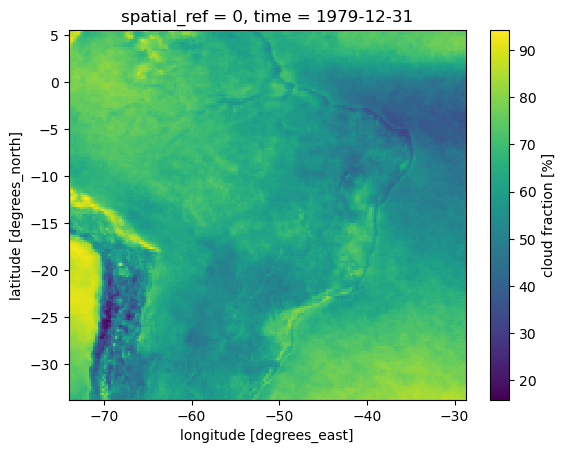

In [56]:
test.sel(time="1979-12-31").plot.imshow()

In [58]:
drainage_polygons = gpd.read_feather("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/drainage/extracted_drainage_polygons.feather")

In [74]:
drainage_polygons_centroids = drainage_polygons[~drainage_polygons.is_empty].centroid

In [85]:
drainage_polygons_centroids

602   0       POINT (-62.53980 -12.67778)
      1       POINT (-62.50310 -12.68933)
      12      POINT (-62.50975 -12.67642)
      14      POINT (-62.60762 -12.67548)
      15      POINT (-62.60507 -12.66303)
                         ...             
1022  1517    POINT (-53.81703 -32.61223)
      1518    POINT (-53.83014 -32.61362)
      1519    POINT (-53.83855 -32.61651)
      1520    POINT (-53.82333 -32.62562)
      1521    POINT (-53.83930 -32.61739)
Length: 1171403, dtype: geometry

In [106]:
tmp = pd.DataFrame(
    {
        "cloud_cover": drainage_polygons_centroids.iloc[:100].apply(lambda x: test.sel(lon=x.x, lat=x.y, method="nearest").values),
        "year": [test.time.dt.year.values] * 100,
        }
    )

tmp.explode(["cloud_cover", "year"]).to_feather("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/cloud_cover/extracted_cloud_cover.feather")

In [92]:
out = pd.DataFrame({tmp.values}, index=tmp.index)    

TypeError: unhashable type: 'numpy.ndarray'

In [80]:
test.sel(lon=drainage_polygons_centroids.iloc[:100].x.values, lat=drainage_polygons_centroids.iloc[:100].y.values, method="nearest")

<xarray.DataArray 'cfc' (time: 42, lat: 100, lon: 100)> Size: 3MB
array([[[68.        , 68.        , 68.        , ..., 69.66666667,
         69.66666667, 69.66666667],
        [68.        , 68.        , 68.        , ..., 69.66666667,
         69.66666667, 69.66666667],
        [68.        , 68.        , 68.        , ..., 69.66666667,
         69.66666667, 69.66666667],
        ...,
        [68.        , 68.        , 68.        , ..., 69.66666667,
         69.66666667, 69.66666667],
        [68.        , 68.        , 68.        , ..., 69.66666667,
         69.66666667, 69.66666667],
        [68.        , 68.        , 68.        , ..., 69.66666667,
         69.66666667, 69.66666667]],

       [[59.91666667, 59.91666667, 59.91666667, ..., 60.16666667,
         60.16666667, 60.16666667],
        [59.91666667, 59.91666667, 59.91666667, ..., 60.16666667,
         60.16666667, 60.16666667],
        [59.91666667, 59.91666667, 59.91666667, ..., 60.16666667,
         60.16666667, 60.16666667],
...
        [59.5       , 59.5       , 59.5       , ..., 59.75      ,
         59.75      , 59.75      ],
        [59.5       , 59.5       , 59.5       , ..., 59.75      ,
         59.75      , 59.75      ],
        [59.5       , 59.5       , 59.5       , ..., 59.75      ,
         59.75      , 59.75      ]],

       [[57.        , 57.        , 57.        , ..., 56.83333333,
         56.83333333, 56.83333333],
        [57.        , 57.        , 57.        , ..., 56.83333333,
         56.83333333, 56.83333333],
        [57.        , 57.        , 57.        , ..., 56.83333333,
         56.83333333, 56.83333333],
        ...,
        [57.        , 57.        , 57.        , ..., 56.83333333,
         56.83333333, 56.83333333],
        [57.        , 57.        , 57.        , ..., 56.83333333,
         56.83333333, 56.83333333],
        [57.        , 57.        , 57.        , ..., 56.83333333,
         56.83333333, 56.83333333]]])
Coordinates:
  * lat          (lat) float32 400B -12.62 -12.62 -12.62 ... -12.62 -12.62
  * lon          (lon) float32 400B -62.62 -62.62 -62.62 ... -62.38 -62.38
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 336B 1979-12-31 1980-12-31 ... 2020-12-31
Attributes:
    long_name:      cloud fraction
    standard_name:  cloud_area_fraction
    units:          %
    valid_min:      0
    valid_max:      100

In [60]:
drainage_polygons.centroid

602   0       POINT (-62.53980 -12.67778)
      1       POINT (-62.50310 -12.68933)
      2                              None
      3                              None
      4                              None
                         ...             
1022  1519    POINT (-53.83855 -32.61651)
      1520    POINT (-53.82333 -32.62562)
      1521    POINT (-53.83930 -32.61739)
      1522                           None
      1523                           None
Length: 2726217, dtype: geometry

---

In [1]:
import os
from urllib.request import urlretrieve
from zipfile import ZipFile
import pandas as pd
import geopandas as gpd
import requests
from bs4 import BeautifulSoup

In [83]:
t_website_index = requests.get("https://www.dpi.inpe.br/prodesdigital/dados/deter_modis_2004_2017")
# parse index
t_website_index_parsed = BeautifulSoup(t_website_index.text, "html.parser")
# get years
t_index_years = pd.Series([x.get("href") for x in t_website_index_parsed.find_all("a")])
t_index_years = t_index_years[t_index_years.str.match(r"\d{4}\/")]

In [84]:
for c_year in t_index_years:
    t_website_index = requests.get(f"https://www.dpi.inpe.br/prodesdigital/dados/deter_modis_2004_2017/{c_year}")
    # parse index
    t_website_index_parsed = BeautifulSoup(t_website_index.text, "html.parser")
    #
    t_index_files = pd.Series([x.get("href") for x in t_website_index_parsed.find_all("a")])
    #
    t_download_files = t_index_files[t_index_files.str.match(r"([Nn]uvem|[Nn]uvens|[Dd]eter)")]
    # download files with urllib
    for c_file in t_download_files:
        if not os.path.exists(f"/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/cloud_cover/raw/{c_year}"):
            os.makedirs(f"/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/cloud_cover/raw/{c_year}")
        if not os.path.exists(f"/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/cloud_cover/raw/{c_year}{c_file}"):
            urlretrieve(f"https://www.dpi.inpe.br/prodesdigital/dados/deter_modis_2004_2017/{c_year}{c_file}", f"/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/cloud_cover/raw/{c_year}{c_file}")

In [88]:
for c_year in t_index_years:
    t_extract_files = os.listdir(f"/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/cloud_cover/raw/{c_year}")
    # extract files
    for c_file in t_extract_files:
        if c_file.endswith(".zip"):
            ZipFile(f"/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/cloud_cover/raw/{c_year}/{c_file}").extractall(f"/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/cloud_cover/raw/{c_year}")

In [141]:
def worker(c_year):
    tmp = pd.Series(os.listdir(f"/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/cloud_cover/raw/{c_year}"))
    return c_year + tmp[tmp.str.contains(r"\.shp$")]

In [217]:
files = pd.DataFrame({"file": pd.concat([worker(file) for file in t_index_years])}).reset_index(drop = True)
files["year"] = files.file.str.extract(r"(\d{4})")

In [7]:
# a dictionary of ALL CAPS month names in brazilian portuguese with their respective number
month_dict = {
    "JANEIRO": "01",
    "JANEIR0": "01",
    "FEVEREIRO": "02",
    "MARCO": "03",
    "MARÇO": "03",
    "ABRIL": "04",
    "MAIO": "05",
    "JUNHO": "06",
    "JULHO": "07",
    "AGOSTO": "08",
    "SETEMBRO": "09",
    "OUTUBRO": "10",
    "NOVEMBRO": "11",
    "DEZEMBRO": "12",
    "jan": "01",
    "fev": "02",
    "mar": "03",
    "abr": "04",
    "mai": "05",
    "jun": "06",
    "jul": "07",
    "ago": "08",
    "set": "09",
    "out": "10",
    "nov": "11",
    "dez": "12",
    "Jan": "01",
    "Fev": "02",
    "Mar": "03",
    "Abr": "04",
    "Mai": "05",
    "Jun": "06",
    "Jul": "07",
    "Ago": "08",
    "Set": "09",
    "Out": "10",
    "Nov": "11",
    "Dez": "12",
    "JAN": "01",
    "FEV": "02",
    "MAR": "03",
    "ABR": "04",
    "MAI": "05",
    "JUN": "06",
    "JUL": "07",
    "AGO": "08",
    "SET": "09",
    "OUT": "10",
    "NOV": "11",
    "DEZ": "12"
}
    

In [220]:
# detect and extract month from file name based on month_dict
files["month"] = files.file.str.extract(r"(" + "|".join(month_dict.keys()) + ")").replace(month_dict)
# if month is not found, get from numeric in file name
files.loc[files.month.isna(), "month"] = files.loc[files.month.isna(), "file"].str.extract(".*_\d{4}(\d{2})\d{2}_.*\.shp", expand=False)
files.loc[files.month.isna(), "month"] = files.loc[files.month.isna(), "file"].str.extract(".*_\d{4}(\d{2})_.*\.shp", expand=False)
files.loc[files.month.isna(), "month"] = files.loc[files.month.isna(), "file"].str.extract(".*_\d{4}_(\d{2}).*\.shp", expand=False)
files.loc[files.month.isna(), "month"] = files.loc[files.month.isna(), "file"].str.extract(".*\d{4}(\d{2})\d{2}.*\.shp", expand=False)
files.loc[files.month.isna(), "month"] = files.loc[files.month.isna(), "file"].str.extract(".*\d{4}(\d{2})\.shp", expand=False)
#files = files.astype({"year": int, "month": int})

In [221]:
files["type"] = files.file.str.contains(r"uvem|uvens", flags=re.IGNORECASE).map({True: "cloud_cover", False: "DETER"})

In [10]:
boundaries = gpd.read_file("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/misc/raw/gadm/gadm41_BRA_2.json", engine="pyogrio")
boundaries["CC_2r"] = boundaries.CC_2.str.slice(0, 6).astype(int)

In [11]:
from tqdm import tqdm
import multiprocessing as mp
from geocube.api.core import make_geocube
import pickle

In [224]:
out_dict = {}

for file in tqdm(files.query("type == 'cloud_cover'").file, total = files.query("type == 'cloud_cover'").file.size):
    
    c_clouds = gpd.read_file(f"/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/cloud_cover/raw/{file}", engine="pyogrio")
    
    if c_clouds.crs is not None:
        c_clouds = c_clouds.to_crs(4326)
    else:
        c_clouds = c_clouds.set_crs(4326)
    
    
    c_clouds["cloud_cover"] = 1
    c_clouds = c_clouds[["cloud_cover", "geometry"]]
    
    cloud_cover_grid = make_geocube(
        vector_data=c_clouds,
        measurements=["cloud_cover"],
        fill = 0,
        output_crs="epsg:4326",
        resolution=(-.01, .01)
    )
    
    boundaries_grid = make_geocube(
        vector_data=boundaries[["CC_2r", "geometry"]],
        like=cloud_cover_grid
    ).CC_2r
    
    cloud_cover_grid["CC_2r"] = boundaries_grid
    
    out_dict[file] = cloud_cover_grid.set_coords("CC_2r").groupby("CC_2r").mean().cloud_cover.to_pandas()
    
pickle.dump(out_dict, open("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/cloud_cover/DETER_cc2r.pkl", "wb"))

100%|██████████| 184/184 [22:11<00:00,  7.24s/it]


In [236]:
out_dict = pickle.load(open("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/cloud_cover/DETER_cc2r.pkl", "rb"))
# turn into long dataframe
out_df = pd.DataFrame(out_dict).transpose().reset_index(names="file").melt(["file"], value_name = "cloud_cover")
# merge with month and year
out_df = pd.merge(files[["file", "year", "month"]], out_df, on="file")
# filter out all CC_2r for which all are NaN or 0
out_df = out_df.groupby('CC_2r').filter(lambda x: not ((x['cloud_cover'] == 0) | (x['cloud_cover'].isna())).all())
# aggregate to yearly mean
out_df_agg = out_df.groupby(["CC_2r", "year"]).agg({"cloud_cover": "mean"}).reset_index().astype({"year": int})
# save to parquet
out_df_agg.to_parquet("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/cloud_cover/cloud_cover_DETER.parquet")

In [211]:
test = gpd.read_file("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/cloud_cover/raw/2011/DETER2011_JANEIR0_NUVEM_pol.shp", engine="pyogrio")

In [1]:
import pandas as pd

In [3]:
# save to parquet
dat = pd.read_parquet(f"/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/cloud_cover/cloud_cover_DETER.parquet")

In [5]:
climate = pd.read_parquet("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/climate/climate_data.parquet")

In [8]:
dat.rename(columns = {"cloud_cover": "cloud_cover_DETER"}, inplace=True)

In [10]:
weather_data_df = pd.merge(climate, dat, on=["CC_2r", "year"], how="outer")

In [11]:
weather_data_df[["CC_2r", "year", "cloud_cover", "cloud_cover_DETER", "temperature", "precipitation"]].to_parquet("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/climate/climate_data.parquet")


<Axes: >

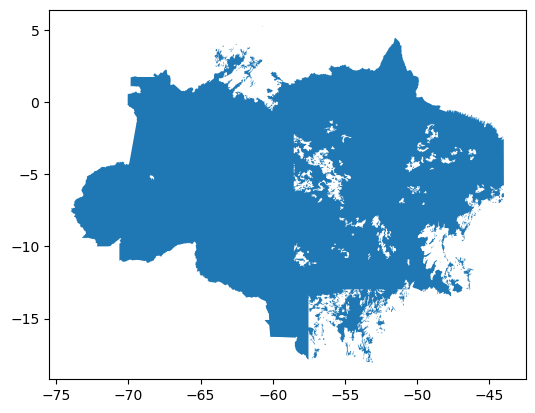

In [213]:
test.plot()

<Axes: >

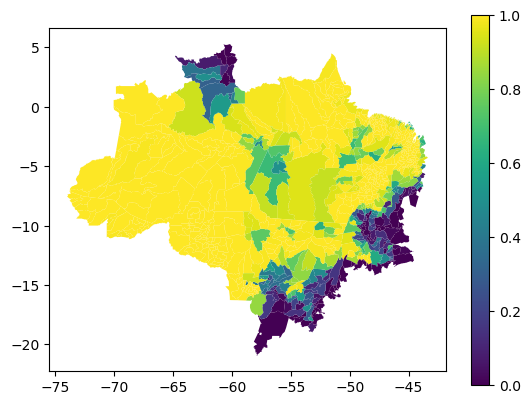

In [233]:
pd.merge(boundaries, out_df.astype({"year": int, "month": int}).query("year==2011 & month==1"), how = "right", on = "CC_2r").plot(column="cloud_cover", legend=True)

,GID_2,GID_0,COUNTRY,GID_1,NAME_1,NL_NAME_1,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry,CC_2r
0,BRA.1.1_2,BRA,Brazil,BRA.1_1,Acre,NA,Acrelândia,NA,NA,Município,Municipality,1200013,NA,"MULTIPOLYGON (((-67.00090 -10.22910, -67.00230...",120001
1,BRA.1.2_2,BRA,Brazil,BRA.1_1,Acre,NA,AssisBrasil,NA,NA,Município,Municipality,1200054,NA,"MULTIPOLYGON (((-69.57420 -10.94520, -69.57700...",120005
2,BRA.1.3_2,BRA,Brazil,BRA.1_1,Acre,NA,Brasiléia,NA,NA,Município,Municipality,1200104,NA,"MULTIPOLYGON (((-69.41280 -10.93710, -69.41410...",120010
3,BRA.1.4_2,BRA,Brazil,BRA.1_1,Acre,NA,Bujari,NA,NA,Município,Municipality,1200138,NA,"MULTIPOLYGON (((-67.97680 -9.35270, -67.97800 ...",120013
4,BRA.1.5_2,BRA,Brazil,BRA.1_1,Acre,NA,Capixaba,NA,NA,Município,Municipality,1200179,NA,"MULTIPOLYGON (((-67.57860 -10.50270, -67.57930...",120017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,BRA.27.135_2,BRA,Brazil,BRA.27_1,Tocantins,NA,Tocantinópolis,NA,NA,Município,Municipality,1721208,NA,"MULTIPOLYGON (((-47.43020 -6.06840, -47.43450 ...",172120
5568,BRA.27.136_2,BRA,Brazil,BRA.27_1,Tocantins,NA,Tupirama,NA,NA,Município,Municipality,1721257,NA,"MULTIPOLYGON (((-48.12560 -8.82120, -48.13910 ...",172125
5569,BRA.27.137_2,BRA,Brazil,BRA.27_1,Tocantins,NA,Tupiratins,NA,NA,Município,Municipality,1721307,NA,"MULTIPOLYGON (((-48.28240 -8.33750, -48.28370 ...",172130
5570,BRA.27.138_2,BRA,Brazil,BRA.27_1,Tocantins,NA,Wanderlândia,NA,NA,Município,Municipality,1722081,NA,"MULTIPOLYGON (((-48.13920 -7.12270, -48.19760 ...",172208


In [176]:
out_dict = {}

for idx, file in tqdm(enumerate(files.query("type == 'DETER'").file), total = files.query("type == 'DETER'").file.size):
    
    c_alerts = gpd.read_file(f"/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/cloud_cover/raw/{file}", engine="pyogrio")
    
    if c_alerts.crs is not None:
        c_alerts = c_alerts.to_crs(4326)
    else:
        c_alerts = c_alerts.set_crs(4326)
    
    
    c_alerts["alert"] = 1
    c_alerts = c_alerts[["alert", "geometry"]]
    
    alert_grid = make_geocube(
        vector_data=c_alerts,
        measurements=["alert"],
        fill = 0,
        output_crs="epsg:4326",
        resolution=(-.01, .01)
    )
    
    boundaries_grid = make_geocube(
        vector_data=boundaries[["CC_2r", "geometry"]],
        like=alert_grid
    ).CC_2r
    
    alert_grid["CC_2r"] = boundaries_grid
    
    out_dict[idx] = alert_grid.set_coords("CC_2r").groupby("CC_2r").mean().alert.to_pandas()
    
    if idx % 10 == 0:
        pickle.dump(out_dict, open("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/cloud_cover/DETER_alerts_cc2r.pkl", "wb"))
    
pickle.dump(out_dict, open("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/cloud_cover/DETER_alerts_cc2r.pkl", "wb"))

  2%|▏         | 3/161 [00:15<13:51,  5.26s/it]/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/setup/miniforge3/envs/thesis/lib/python3.9/site-packages/pyogrio/raw.py:196: RuntimeWarning: /pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/cloud_cover/raw/2004/Deter_20040622_pol.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
 51%|█████     | 82/161 [05:15<04:35,  3.49s/it]/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/setup/miniforge3/envs/thesis/lib/python3.9/site-packages/rasterio/features.py:328: ShapeSkipWarning: Invalid or empty shape None at index 378 will not be rasterized.
  warnings.warn('Invalid or empty shape {} at index {} will not be rasterized.'.format(geom, index), ShapeSkipWarning)
100%|██████████| 161/161 [10:36<00:00,  3.95s/it]


In [178]:
pd.DataFrame(out_dict).transpose().reset_index(names="file_id").melt(["file_id"], value_name = "deter_alerts")

,file_id,CC_2r,deter_alerts
0,0,110001.0,0.000000
1,1,110001.0,NaN
2,2,110001.0,NaN
3,3,110001.0,0.002041
4,4,110001.0,0.001361
...,...,...,...
182730,156,530010.0,NaN
182731,157,530010.0,NaN
182732,158,530010.0,NaN
182733,159,530010.0,0.000000


In [179]:
# turn into long dataframe
out_df = pd.DataFrame(out_dict).transpose().reset_index(names="file_id").melt(["file_id"], value_name = "deter_alerts")
# merge with month and year
out_df = pd.merge(files.query("type=='DETER'").reset_index(drop=True)[["year", "month"]], out_df, left_index=True, right_on="file_id").drop(columns="file_id")

In [180]:
out_df

,year,month,CC_2r,deter_alerts
0,2004,09,110001.0,0.000000
161,2004,09,110002.0,0.000000
322,2004,09,110003.0,0.000000
483,2004,09,110004.0,0.000000
644,2004,09,110005.0,0.000431
...,...,...,...,...
182090,2017,09,522200.0,NaN
182251,2017,09,522205.0,NaN
182412,2017,09,522220.0,0.000000
182573,2017,09,522230.0,0.000000


In [78]:
# turn into long dataframe
out_df = pd.DataFrame(out_dict).transpose().reset_index(names="file_id").melt(["file_id"], value_name = "deter_alerts")
# merge with month and year
out_df = pd.merge(files.query("type=='DETER'").reset_index(drop=True)[["year", "month"]], out_df, left_index=True, right_on="file_id").drop(columns="file_id")
# filter out all CC_2r for which all are NaN or 0
out_df = out_df.groupby('CC_2r').filter(lambda x: not ((x['cloud_cover'] == 0) | (x['cloud_cover'].isna())).all())
# "When visibility is too precarious throughout the entire month to derive any information about land cover, however, no data is produced for that month we follow INPE's recommendation and assume DETER cloud coverage to be complete in this case."
#out_df.loc[out_df.cloud_cover == 0, "cloud_cover"] = 1
# aggregate to yearly mean
out_df_agg = out_df.groupby(["CC_2r", "year"]).agg({"cloud_cover": "mean"}).reset_index()
# save to parquet
out_df_agg.to_parquet("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/cloud_cover/cloud_cover_DETER.parquet")

In [79]:
out_df_agg

,CC_2r,year,cloud_cover
0,110001.0,2005,0.366808
1,110001.0,2006,0.635388
2,110001.0,2007,0.627701
3,110001.0,2008,0.794072
4,110001.0,2009,0.728320
...,...,...,...
10434,522020.0,2013,0.875073
10435,522020.0,2014,1.000000
10436,522020.0,2015,0.857226
10437,522020.0,2016,0.834113


In [81]:
out_df.sort_values(["year", "month"]).query("CC_2r == 522020 & year == 2014")#.cloud_cover.plot(kind="box")

,year,month,CC_2r,cloud_cover
205303,2014,1,522020.0,1.0
205305,2014,2,522020.0,1.0
205307,2014,3,522020.0,1.0
205306,2014,4,522020.0,1.0
205312,2014,5,522020.0,1.0
205304,2014,6,522020.0,NaN
205308,2014,7,522020.0,NaN
205310,2014,8,522020.0,NaN
205311,2014,9,522020.0,NaN
205309,2014,10,522020.0,1.0


In [60]:
out_df

,year,month,CC_2r,cloud_cover
0,2005,6,110001.0,0.0
185,2005,6,110002.0,0.0
370,2005,6,110003.0,NaN
555,2005,6,110004.0,0.0
740,2005,6,110005.0,NaN
...,...,...,...,...
209234,2017,11,522200.0,0.0
209419,2017,11,522205.0,NaN
209604,2017,11,522220.0,0.0
209789,2017,11,522230.0,0.0


In [58]:
out_df_agg

cloud_cover
CC_2r    year             
110001.0 2005     0.033475
         2006     0.135388
         2007     0.215936
         2008     0.365500
         2009     0.394987
...                    ...
522020.0 2013     0.000073
         2014     0.000000
         2015     0.000084
         2016     0.000780
         2017     0.000223

[10439 rows x 1 columns]

In [55]:
out_df_agg.index.get_level_values("CC_2r").unique()

Index([110001.0, 110002.0, 110003.0, 110004.0, 110005.0, 110006.0, 110007.0,
       110008.0, 110009.0, 110010.0,
       ...
       521308.0, 521310.0, 521350.0, 521370.0, 521377.0, 521483.0, 521525.0,
       521800.0, 521940.0, 522020.0],
      dtype='float64', name='CC_2r', length=803)

In [41]:
out_df.CC_2r.nunique()

1135

<Axes: ylabel='Frequency'>

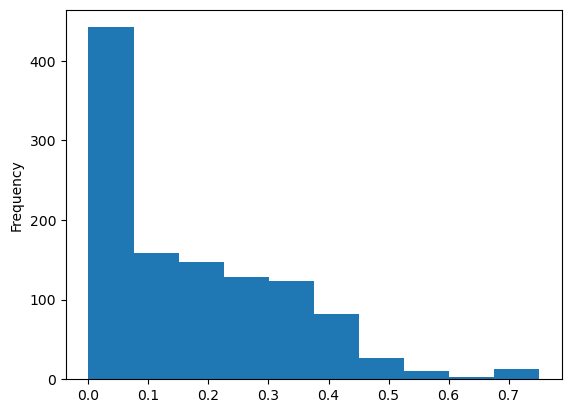

In [40]:
out_df["test_na"] = out_df.cloud_cover.isna()
out_df.groupby("CC_2r").test_na.mean().plot.hist()

In [38]:
out_df

,year,month,CC_2r,cloud_cover
0,2005,6,110001.0,0.0
185,2005,6,110002.0,0.0
370,2005,6,110003.0,NaN
555,2005,6,110004.0,0.0
740,2005,6,110005.0,NaN
...,...,...,...,...
209234,2017,11,522200.0,0.0
209419,2017,11,522205.0,NaN
209604,2017,11,522220.0,0.0
209789,2017,11,522230.0,0.0


<Axes: >

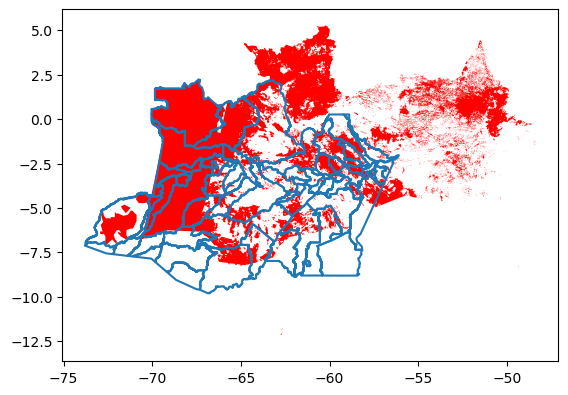

In [105]:
ax = boundaries.query("NAME_1 == 'Amazonas'").boundary.plot()
c_clouds.plot(ax=ax, color = "red")

---

In [2]:
import pandas as pd
import geopandas as gpd

In [41]:
test = gpd.read_file("/Users/felixschulz/Downloads/Nuvens_201504_shp/DETER2015_ABRIL_NUVEM_pol.shp", engine = "pyogrio")

<Axes: >

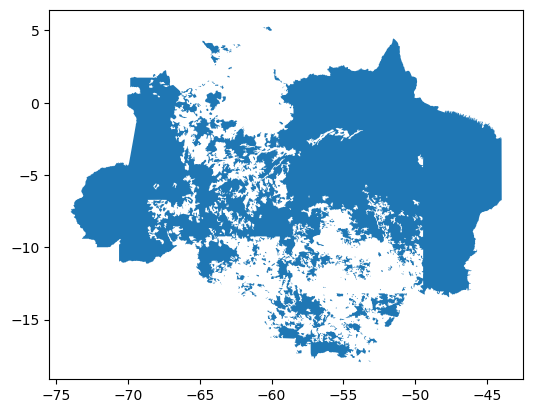

In [9]:
test.plot()

In [36]:
test = gpd.read_file("/Users/felixschulz/Library/CloudStorage/OneDrive-Personal/Dokumente/Uni/Masterthesis/data/cloud_cover/Deter_201207_shp/deter_201207.shp", engine = "pyogrio")

In [39]:
gpd.GeoDataFrame(test[test.geometry.type == "Polygon"], geometry = test[test.geometry.type == "Polygon"].geometry, crs = 4618).area.sum()

/var/folders/56/097r5m_53z97wd0wwmqws76m0000gn/T/ipykernel_9390/760176497.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gpd.GeoDataFrame(test[test.geometry.type == "Polygon"], geometry = test[test.geometry.type == "Polygon"].geometry, crs = 4618).area.sum()


0.017547727821637164

<Axes: >

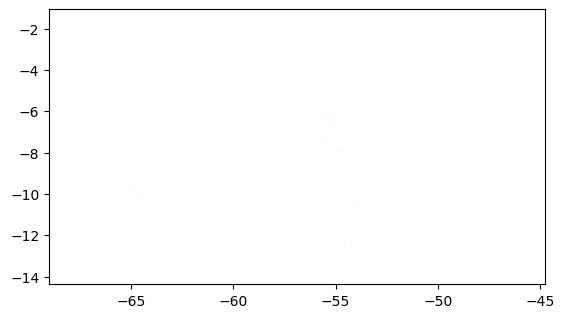

In [37]:
gpd.GeoDataFrame(test[test.geometry.type == "Polygon"], geometry = test[test.geometry.type == "Polygon"].geometry, crs = 4618).plot()

In [21]:
test = test.set_crs(4326).set_geometry("geometry")

In [27]:
test.is_valid

0      True
1      True
2      True
3      True
4      True
       ... 
293    True
294    True
295    True
296    True
297    True
Length: 298, dtype: bool

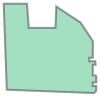

In [33]:
test.geometry.iloc[4]

---

In [1]:
import os, sys, re
import pandas as pd
sys.path.append("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/code")
os.chdir("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis")

from data.download import download_agent
from data.preprocess.misc import preprocess_boundaries
from data.preprocess.river_network import preprocess_rivers, river_network

fetch_instructions = pd.read_json("setup/fetch.json")
def get_fetch_instructions(id):
    return fetch_instructions[fetch_instructions["id"] == id].to_dict(orient = "records")[0]

agent = download_agent("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/", "BRA", 2010)

KeyboardInterrupt: 

In [12]:
agent.fetch(get_fetch_instructions("cl_noaa_temp"))

In [17]:
agent.fetch(get_fetch_instructions("cl_noaa_precip"))

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
from geocube.api.core import make_geocube

In [2]:
boundaries = gpd.read_file("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/misc/raw/gadm/gadm41_BRA_2.json", engine="pyogrio")
boundaries["CC_2r"] = boundaries.CC_2.str.slice(0, 6).astype(int)

In [3]:
precipitation = xr.open_mfdataset("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/climate/raw/precip.*.nc", chunks = "auto", decode_times=True, decode_cf = True)
temperature = xr.open_mfdataset("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/climate/raw/tmax.*.nc", chunks = "auto", decode_times=True, decode_cf = True)

In [4]:
weather_data = xr.merge([temperature, precipitation])

In [5]:
# apply function to precipitation
weather_data = weather_data.assign_coords({"lon": (np.vectorize(lambda lon: lon - 360 if lon > 180 else lon)(precipitation.lon))})
# sort by lon
weather_data = weather_data.sortby("lon")
# set CRS
weather_data = weather_data.rio.write_crs("epsg:4326").rio.set_spatial_dims(x_dim="lon", y_dim="lat").rio.write_coordinate_system(inplace=True)

In [6]:
# subset
weather_data = weather_data.rio.clip_box(*boundaries.total_bounds).persist()

In [14]:
cloud_cover = xr.open_mfdataset(
    "/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/cloud_cover/raw/*.nc", 
    chunks = "auto", decode_times=True, decode_cf = True
    )
cloud_cover = cloud_cover.cfc.reindex_like(weather_data, method="nearest").persist()

In [18]:
weather_data["cloud_cover"] = cloud_cover

In [19]:
# resample by year
weather_data = weather_data.resample(time="1Y").mean().load()

/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/setup/miniforge3/envs/thesis/lib/python3.9/site-packages/xarray/core/groupby.py:668: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(


In [20]:
# turn boundaries into a grid
boundaries_grid = make_geocube(
    vector_data=boundaries[["CC_2r", "geometry"]],
    like=weather_data
).CC_2r.rename({"x": "lon", "y": "lat"})

# merge
weather_data["CC_2r"] = boundaries_grid

In [22]:
# get mean by CC_2r
weather_data_df = weather_data.groupby("CC_2r").mean().to_dataframe()
weather_data_df = weather_data_df.reset_index().drop(columns="spatial_ref")

# an extraction worker
def worker(x):
    tmp = weather_data.sel(lon=x.x, lat=x.y, method="nearest")
    return pd.DataFrame({"time": tmp.time.values, "cloud_cover": tmp.cloud_cover.values, "tmax": tmp.tmax.values, "precip": tmp.precip.values})
# extract closest for those that are too small for rasterization
weather_data_df_merge = pd.concat(boundaries[~boundaries.CC_2r.isin(weather_data_df.CC_2r.unique())].set_index("CC_2r").centroid.apply(worker).to_dict())
weather_data_df_merge = weather_data_df_merge.reset_index(names = ["CC_2r", "t"]).drop(columns="t")

# combine
weather_data_df = pd.concat([weather_data_df, weather_data_df_merge])

/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/setup/miniforge3/envs/thesis/lib/python3.9/site-packages/xarray/core/dataset.py:4744: UserWarning: No index created for dimension CC_2r because variable CC_2r is not a coordinate. To create an index for CC_2r, please first call `.set_coords('CC_2r')` on this object.
  warnings.warn(
/scratch/slurm_tmpdir/job_23845379/ipykernel_72563/1527387662.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  weather_data_df_merge = pd.concat(boundaries[~boundaries.CC_2r.isin(weather_data_df.CC_2r.unique())].set_index("CC_2r").centroid.apply(worker).to_dict())


In [24]:
weather_data_df["year"] = pd.to_datetime(weather_data_df.time).dt.year
weather_data_df = weather_data_df.drop(columns="time")
weather_data_df = weather_data_df.rename(columns={"tmax": "temperature", "precip": "precipitation"})

In [28]:
weather_data_df[["CC_2r", "year", "cloud_cover", "temperature", "precipitation"]].to_parquet("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/climate/climate_data.parquet")